    Name: Arturo Perez 
    Email: arturo.e.perez@vanderbilt.edu
    VUnet: perezae
    Course: CS 3891 
    Date: 3 April 2018 

# 0. Helper Functions
We begin this assignment by defining the activation functions we will use later on. These include ReLU, Sigmoid, and their respective derivatives when applicable.

In [19]:
#   ReLU activation function
def ReLU (array):
    return np.maximum(0, array)
    
#   derivative of ReLU activation function
def dReLU(array):
    array[array < 0] = 0
    array[array > 0] = 1
    return array

#   Sigmoid activation function
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

We continue by defining a checkAccuracy function that will calculate our accuracy and error rates of our learning models.

In [20]:
#   compute the training and the test error
def checkAccuracy(w, b , X, Y, T, neuralnetworkType) :
    # initialize our paramters for use in forward propogation 
    z = [None] * len(w)
    a = [None] * len(w)

    # forward propopgation 
    # we use a[-1] (the a from the very last layer) to get our prediction labels
    z[0] = w[0] @ X + b[0]
    for i in range(len(w)-1):
        a[i] = ReLU(z[i])
        z[i+1] = w[i+1] @ a[i] + b[i+1]
    a[-1] = sigmoid(z[-1])

    # get the prediction labels  
    result = np.where(a[-1] >= 0.5, 1.0, 0.0)

    # compare our prediction labels to the actual labels (Y in this case)
    dim = result.ndim
    count = 0
    if (dim == 1) :
        for i in range(1, Y.size):
            if result[i] == Y[0, i]:
                count += 1
    else :       
        for i in range(1, Y.size):
            if result[0, i] == Y[0, i]:
                count += 1

    # calculate accuracy and error rates 
    accuracy = (count/Y.shape[1]) * 100
    error_rate = 100 - accuracy

    # print results 
    print(T + " accuracy rate for " + neuralnetworkType + " is : " + str(accuracy) + "%")
    print(T + " error rate for " + neuralnetworkType + " is : " + str(error_rate) + "%")
    print(" ")

## 1. Preprocessing 
###### In this section we take care of preprocessing the MNIST data set.
We start by reading in the MNIST data set. We seperate the training and testing data into 4 buffers.

In [21]:
import os, sys
import numpy as np
import struct
from scipy.special import expit
import matplotlib.pyplot as plt
from mnist import MNIST
import functools
from mlxtend.preprocessing import shuffle_arrays_unison


# the training set is stored in this directory
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"

# load the MNIST data
mndata = MNIST(path)
train_images, train_labels = mndata.load_training() # training data
test_images, test_labels = mndata.load_testing() # testing data

We continue by reshaping/rescaling the images and labels of both the training and test data.

In [22]:
# convert to (28x28,1) column vector and divide by 255
training_size, test_size = 60000, 10000   

train_images = np.array(train_images[:training_size], dtype=float).transpose() / 255
train_labels = np.array(train_labels[:training_size], dtype=float)
test_images = np.array(test_images[:test_size], dtype=float).transpose() / 255
test_labels = np.array(test_labels[:test_size], dtype = float)
train_labels = np.reshape(train_labels, (training_size, 1))
test_labels = np.reshape(test_labels, (test_size, 1))

# subset of 10,000 samples
subsetX = train_images[:,10000:20000]
subsetY = train_labels[10000:20000,:]

Because we want to predict whether a new image is equal to ID or not, we change the labels from train_labels and test_labels to be either 1 if they are equal to ID, or 0 if they are not. This will help us make our predictions later on and calculate the accuracy/error rates. In my case, ID is equal to 6. 

In [23]:
# student ID
ID = 6
# change the labels to either 0 or 1
def relabel(label):
    for l in label:
        if (l[0] == ID):
            l[0] = 1
        else:
            l[0] = 0
            
relabel(train_labels)
relabel(test_labels)

## 2. Adam
Now we train a 3-layer neural to classify the data using Adam. We plot the cost function, as well as calculate the training and test error. 

#### Full Disclaimer 

I spent many hours working on and debugging this project, but in the end I could not figure out all of my bugs. Here are the results of my code.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

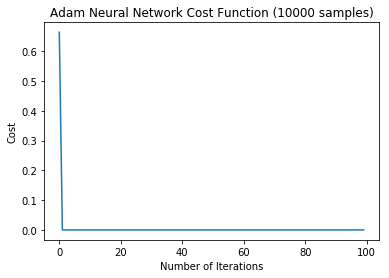

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [24]:
def getNextMiniBatch(X, Y, batchSize) :
    for i in range(0, X.shape[1], batchSize) :
        yield (X[: , i:i + batchSize] , Y[:, i:i + batchSize ])

def minibatchNeuralNetwork(p, q, p1, p2, alpha, batchSize, layer_list):
    f, m = p.shape
    
    # initialize weights, biases and parameters 
    w = functools.reduce(lambda acc, neurons: (acc[0] + [np.random.randn(neurons, 
    acc[1]) * np.sqrt(2.0/acc[1])], neurons), layer_list, ([], f))[0]
    b = [ np.random.randn(neurons, 1) * 0.01 for neurons in layer_list ]
    Ba0 = [ np.zeros((neurons, 1)) for neurons in layer_list ]
    Ba1 = [ np.zeros((neurons, 1)) for neurons in layer_list ]
    z = [None] * len(w)
    a = [None] * len(w)
    costs = []

    newLayerList = [f]
    for i in range (0, len(layer_list)) :
        newLayerList.append(layer_list[i])

    Wa0 = []
    Wa1 = []
    for i in range (1, len(newLayerList)) :
        Wa0.append(np.random.randn(newLayerList[i], newLayerList[i-1]))
        Wa1.append(np.random.randn(newLayerList[i], newLayerList[i-1]))

    for i in range(0, 100):
        # api function used to shuffle 2 numpy arrays in unison
        p, q = shuffle_arrays_unison(arrays=[p.T, q.T], random_seed=3)
        p = p.T
        q = q.T

        # for each minibatch: forward prop, compute cost, backward prop, update parameters
        for X, Y in getNextMiniBatch(p, q, batchSize) :
            # forward propopgation
            z[0] = w[0] @ X + b[0]
            for i in range(len(w)-1):
                a[i] = ReLU(z[i])
                z[i+1] = w[i+1] @ a[i] + b[i+1]
            a[-1] = sigmoid(z[-1])

            # compute cost
            cost = np.nan_to_num(- (Y @ np.log(a[-1].T) + (1 - Y) @ np.log(1 - a[-1].T))[0,0] / m)
            costs.append(cost)

            dZ = a[-1] - Y
            gradients = [] 
            # backward propogation 
            for k in range(len(z)-2, -1, -1):
                # Calculate dW and DB
                gradients.append([ (dZ @ a[k].T) / m, 
                    np.sum(dZ, axis=1).reshape(b[k+1].shape) / m ])
            
                dZ = (w[k+1].T @ dZ) * dReLU(z[k])

            # Calculate dW and dB for the first layer
            gradients.append([ (dZ @ X.T) / m, 
                np.sum(dZ, axis=1).reshape(b[0].shape) / m ])

            # flip gradients so order is from first to last layer
            gradients = gradients[::-1]

            # Adam updates
            for j in range(len(gradients)):
                Wa0[j] = ((p1 * Wa0[j]) + ((1-p1) * gradients[j][0])) / (1-p1**i)
                Wa1[j] = ((p2 * Wa1[j]) + ((1-p2) * gradients[j][0]*gradients[j][0])) / (1-p2**i)
                Ba0[j] = ((p1 * Ba0[j]) + ((1-p1) * gradients[j][1])) / (1-p1**i)
                Ba1[j] = ((p2 * Ba1[j]) + ((1-p2) * gradients[j][1]*gradients[j][1])) / (1-p2**i)

                w[j] = w[j] - alpha*(Wa0[j] / (Wa1[j]**(1/2) + .000001))
                b[j] = b[j] - alpha*(Ba0[j] / (Ba1[j]**(1/2) + .000001))

    # plot cost function
    plt.clf()
    plt.plot(costs)
    plt.title("Adam Neural Network Cost Function (" + str(m) + " samples)")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show() 
    return(w, b)
 
layers = [20, 10]
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .9, .9, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

## 3. Investigate the impact of the hyperparameters 

I cannot say conclusively how changing the hyperparameters affects the results as my code has a bug in it. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

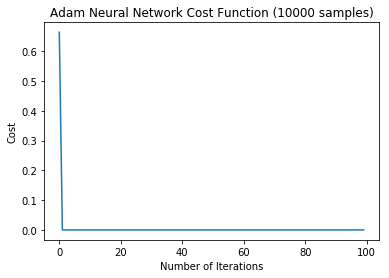

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [25]:
layers = [20, 10]
# p1 = .9, p2 = .9
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .9, .9, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

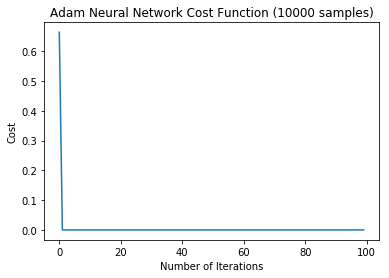

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [26]:
layers = [20, 10]
# p1 = .99, p2 = .9
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .99, .9, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

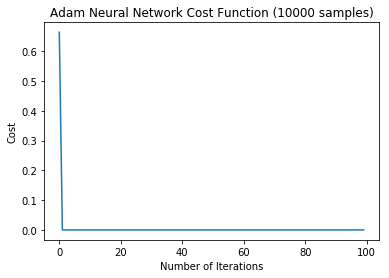

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [27]:
layers = [20, 10]
# p1 = .9, p2 = .99
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .9, .99, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

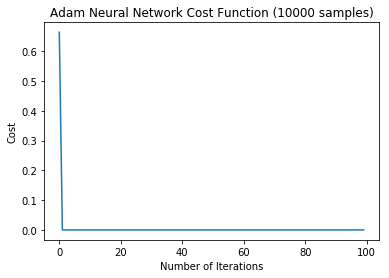

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [28]:
layers = [20, 10]
# p1 = .99, p2 = .99
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .99, .99, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

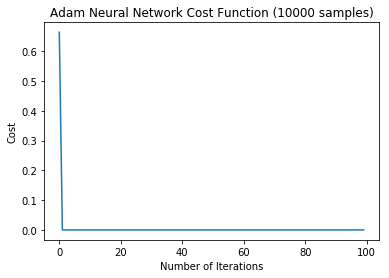

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [29]:
layers = [20, 10]
# p1 = .5, p2 = .9
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .5, .9, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda3/lib/python3

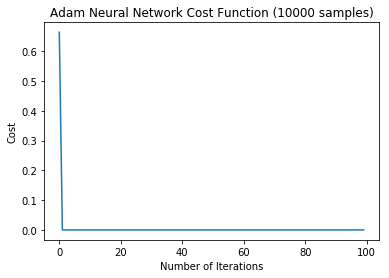

Train accuracy rate for Adam Neural Network is : 90.42%
Train error rate for Adam Neural Network is : 9.579999999999998%
 
Test accuracy rate for Adam Neural Network is : 90.41%
Test error rate for Adam Neural Network is : 9.590000000000003%
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [31]:
layers = [20, 10]
# p1 = .5, p2 = .5
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .5, .5, .001, 10000, layers)
neuralType = "Adam Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)